In [18]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

print(f"TensorFlow version: {tf.__version__}")
print(f"Numpy version: {np.__version__}")

TensorFlow version: 2.18.0
Numpy version: 1.26.4


In [19]:
# Create necessary directories
os.makedirs(os.path.join(BASE_DIR, 'dataset'), exist_ok=True)
os.makedirs(os.path.join(BASE_DIR, 'Checkpoints', 'RML22.01A'), exist_ok=True)
os.makedirs(os.path.join(BASE_DIR, 'Results', 'RML22.01A'), exist_ok=True)
os.makedirs(os.path.join(BASE_DIR, 'Scripts'), exist_ok=True)
os.makedirs(os.path.join(BASE_DIR, 'figures'), exist_ok=True)

print("Directory structure created successfully!")
print(f"Checkpoints: {os.path.join(BASE_DIR, 'Checkpoints')}")
print(f"Results: {os.path.join(BASE_DIR, 'Results')}")

Directory structure created successfully!
Checkpoints: /kaggle/working/AMC_project/Checkpoints
Results: /kaggle/working/AMC_project/Results


In [20]:
# Dataset path configuration
if IS_KAGGLE:
    # Update this path to match your Kaggle dataset location
    # Example: '/kaggle/input/your-dataset-name/RML22.01A.pkl'
    DATASET_PATH = '/kaggle/input/rml22-dataset/RML22.01A.pkl'
else:
    DATASET_PATH = os.path.join(BASE_DIR, 'dataset', 'RML22.01A.pkl')

# Verify dataset exists
if os.path.exists(DATASET_PATH):
    print(f"✓ Dataset found at: {DATASET_PATH}")
    print(f"  Size: {os.path.getsize(DATASET_PATH) / (1024**3):.2f} GB")
else:
    print(f"✗ Dataset NOT found at: {DATASET_PATH}")
    print("  Please upload the dataset and update DATASET_PATH variable")

✓ Dataset found at: /kaggle/input/rml22-dataset/RML22.01A.pkl
  Size: 0.44 GB


In [21]:
def load_data(filename, snr_min=None, snr_max=None):
    """
    Load RML22.01A dataset with optional SNR filtering
    
    Args:
        filename: path to RML22.01A.pkl
        snr_min: minimum SNR to include (None = no minimum)
        snr_max: maximum SNR to include (None = no maximum)
    
    Returns:
        (mods, snrs_kept, lbl), (X_train, Y_train), (X_val, Y_val), (X_test, Y_test), (train_idx, val_idx, test_idx)
    """
    print(f"Loading dataset from: {filename}")

    Xd = pickle.load(open(filename, 'rb'), encoding='iso-8859-1')
    mods, snrs_all = [sorted(list(set([k[j] for k in Xd.keys()]))) for j in [0, 1]]

    print(f"Found modulations: {mods}")
    print(f"Found SNRs: {snrs_all}")

    # Ensure snr_min and snr_max are floats if not None
    snr_min = float(snr_min) if snr_min is not None else None
    snr_max = float(snr_max) if snr_max is not None else None
    snrs_kept = [s for s in snrs_all if (snr_min is None or s >= snr_min) and (snr_max is None or s <= snr_max)]
    print(f"SNRs kept after filtering (>= {snr_min}): {snrs_kept}")

    if not snrs_kept:
        raise ValueError("No SNRs remain after filtering. Check snr_min/snr_max.")

    X, lbl = [], []
    for mod in mods:
        for snr in snrs_kept:
            block = Xd[(mod, snr)]
            X.append(block)
            lbl.extend([(mod, snr)] * block.shape[0])

    X = np.vstack(X)
    print(f"Stacked X shape: {X.shape}")

    n_examples = X.shape[0]
    np.random.seed(2016)
    indices = np.arange(n_examples)
    np.random.shuffle(indices)

    n_train = int(0.7 * n_examples)
    n_val = int(0.15 * n_examples)
    print(f"Total examples: {n_examples}, Train: {n_train}, Val: {n_val}, Test: {n_examples - n_train - n_val}")

    train_idx = indices[:n_train].tolist()
    val_idx = indices[n_train:n_train+n_val].tolist()
    test_idx = indices[n_train+n_val:].tolist()

    X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
    print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

    def to_onehot(indices):
        yy = np.zeros([len(indices), len(mods)], dtype=np.float32)
        yy[np.arange(len(indices)), indices] = 1.0
        return yy

    Y_train = to_onehot([mods.index(lbl[i][0]) for i in train_idx])
    Y_val   = to_onehot([mods.index(lbl[i][0]) for i in val_idx])
    Y_test  = to_onehot([mods.index(lbl[i][0]) for i in test_idx])

    return (mods, snrs_kept, lbl), (X_train, Y_train), (X_val, Y_val), (X_test, Y_test), (train_idx, val_idx, test_idx)

In [22]:
def relu(x):
    return tf.nn.relu(x)

def sepconv2d_bn(x, filters, k, dil=(1,1), name="s2d"):
    x = L.SeparableConv2D(filters, k, padding="same", dilation_rate=dil, use_bias=False, name=f"{name}_conv")(x)
    x = L.BatchNormalization(name=f"{name}_bn")(x)
    x = L.Activation(relu, name=f"{name}_relu")(x)
    return x

def sepconv1d_bn(x, filters, k, dil=1, name="s1d"):
    x = L.SeparableConv1D(filters, k, padding="same", dilation_rate=dil, use_bias=False, name=f"{name}_conv")(x)
    x = L.BatchNormalization(name=f"{name}_bn")(x)
    x = L.Activation(relu, name=f"{name}_relu")(x)
    return x

def tcn_block(x, filters, k=5, dil=1, drop=0.1, name="tcn"):
    h = sepconv1d_bn(x, filters, k, dil=dil, name=f"{name}_a")
    h = L.SpatialDropout1D(drop, name=f"{name}_drop")(h)
    h = sepconv1d_bn(h, filters, k, dil=1, name=f"{name}_b")
    if x.shape[-1] != filters:
        x = L.Conv1D(filters, 1, padding="same", use_bias=False, name=f"{name}_proj")(x)
        x = L.BatchNormalization(name=f"{name}_proj_bn")(x)
    out = L.Add(name=f"{name}_add")([x, h])
    out = L.Activation(relu, name=f"{name}_out")(out)
    return out

def Model_(classes=11, filters=(16, 32, 64), dropout_rate=0.3, tcn_filters=64, tcn_k=5, tcn_dils=(1,), lstm_units=64):
    F1, F2, F3 = filters
    inp_iq = L.Input((2, 128, 1), name="IQchannel")
    inp_i  = L.Input((128, 1),   name="Ichannel")
    inp_q  = L.Input((128, 1),   name="Qchannel")

    # Spatial feature extraction
    x_iq = sepconv2d_bn(inp_iq, F1, (2,8), dil=(1,1), name="iq_s1")
    x_iq = sepconv2d_bn(x_iq,   F2, (2,8), dil=(2,2), name="iq_s2")

    x_i  = sepconv1d_bn(inp_i,  F1, 8, dil=1, name="i_s1")
    x_i  = sepconv1d_bn(x_i,    F2, 8, dil=1, name="i_s2")
    x_i  = L.Reshape((1, 128, F2), name="reshape_I")(x_i)

    x_q  = sepconv1d_bn(inp_q,  F1, 8, dil=1, name="q_s1")
    x_q  = sepconv1d_bn(x_q,    F2, 8, dil=1, name="q_s2")
    x_q  = L.Reshape((1, 128, F2), name="reshape_Q")(x_q)

    x_stack = L.Concatenate(axis=1, name="stack_IQ_1d")([x_i, x_q])
    x_fuse  = sepconv2d_bn(x_stack, F2, (2,8), dil=(1,1), name="fuse_s1")

    x_spatial = L.Concatenate(name="concat_spatial")([x_iq, x_fuse])
    x_spatial = sepconv2d_bn(x_spatial, F3, (2,5), dil=(1,1), name="spatial_final")
    x_time = L.Reshape((-1, F3), name="reshape_time")(x_spatial)

    # TCN stack
    for idx, dil in enumerate(tcn_dils):
        x_time = tcn_block(x_time, tcn_filters, k=tcn_k, dil=dil, drop=0.1, name=f"tcn{idx+1}")

    # Recurrent block: GRU
    x_seq = L.GRU(lstm_units, return_sequences=True, dropout=0.1, name="GRU")(x_time)

    if x_seq.shape[-1] != F3:
        x_seq = L.Dense(F3, name="proj_to_d")(x_seq)

    # Global pooling
    x = L.GlobalAveragePooling1D(name="gap")(x_seq)
    
    # Classifier head
    x = L.Dense(128, activation=relu, name="FC1")(x)
    x = L.Dropout(dropout_rate, name="drop1")(x)
    x = L.Dense(64, activation=relu, name="FC2")(x)
    x = L.Dropout(dropout_rate, name="drop2")(x)
    out = L.Dense(classes, activation="softmax", name="Softmax")(x)
    
    model = Model(inputs=[inp_iq, inp_i, inp_q], outputs=out, name="Model_")
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [23]:
def train_model(model, X_IQ_train, X_I_train, X_Q_train, Y_train, 
                X_IQ_val, X_I_val, X_Q_val, Y_val, 
                checkpoint_path=None, epochs=5):
    """
    Train the model with callbacks
    """
    callbacks = [
        ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=5, verbose=1),
        EarlyStopping(monitor="val_loss", patience=20, verbose=1, restore_best_weights=True)
    ]
    
    history = model.fit(
        [X_IQ_train, X_I_train, X_Q_train], Y_train,
        batch_size=512, epochs=epochs,
        validation_data=([X_IQ_val, X_I_val, X_Q_val], Y_val),
        callbacks=callbacks
    )
    
    return model, checkpoint_path, history

In [24]:
def _plot_cm(cm, class_names, title, save_path, normalize=False):
    """Plot and save a confusion matrix (optionally row-normalized)."""
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', aspect='auto')
    ax.figure.colorbar(im, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

    # ticks
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names)

    # annotate
    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max() if cm.size else 0) / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            ax.text(j, i, format(val, fmt),
                    ha="center", va="center",
                    color="white" if val > thresh else "black")
    fig.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=160)
    plt.close(fig)

def snrwise_evaluation(
    result_folder, model,
    X_IQ_test, X_I_test, X_Q_test, Y_test,
    mods, snrs_kept, lbl, test_idx,
    batch_size=1024, do_plot=True
):
    os.makedirs(result_folder, exist_ok=True)
    class_names = [str(m) for m in mods]
    n_classes = len(class_names)

    # Predict once over the whole test set
    print("\nGenerating predictions...")
    y_pred = model.predict([X_IQ_test, X_I_test, X_Q_test], batch_size=batch_size, verbose=0)
    y_true_cls = np.argmax(Y_test, axis=1)
    y_pred_cls = np.argmax(y_pred, axis=1)

    # Overall classification report
    overall_cr = classification_report(y_true_cls, y_pred_cls, target_names=class_names, digits=4)
    print("\n=== Classification Report (Overall) ===")
    print(overall_cr)
    with open(os.path.join(result_folder, "overall_classification_report.txt"), "w") as f:
        f.write(overall_cr + "\n")

    # Build SNR map for the test rows
    snr_per_row = np.array([lbl[orig_idx][1] for orig_idx in test_idx], dtype=int)

    # SNR-wise accuracy table
    print("\n=== SNR-wise Accuracy (Test set) ===")
    totals = {}
    correct = {}
    for snr in snrs_kept:
        totals[snr] = 0
        correct[snr] = 0

    for i in range(len(y_true_cls)):
        snr = snr_per_row[i]
        if snr not in totals:
            totals[snr] = 0
            correct[snr] = 0
        totals[snr] += 1
        if y_pred_cls[i] == y_true_cls[i]:
            correct[snr] += 1

    snr_sorted = sorted(totals.keys())
    print(f"{'SNR(dB)':>8} | {'N':>7} | {'Correct':>8} | {'Acc':>8}")
    print("-"*42)
    
    for snr in snr_sorted:
        n = totals[snr]
        acc = (correct[snr] / n) if n > 0 else float('nan')
        print(f"{snr:8} | {n:7d} | {correct[snr]:8d} | {acc:8.4f}")

    with open(os.path.join(result_folder, "snrwise_accuracy.txt"), "w") as f:
        f.write(f"{'SNR(dB)':>8} | {'N':>7} | {'Correct':>8} | {'Acc':>8}\n")
        f.write("-"*42 + "\n")
        for snr in snr_sorted:
            n = totals[snr]
            acc = (correct[snr] / n) if n > 0 else float('nan')
            f.write(f"{snr:8} | {n:7d} | {correct[snr]:8d} | {acc:8.4f}\n")

    # Per-SNR confusion matrices & classification reports
    for snr in snr_sorted:
        idx = np.where(snr_per_row == snr)[0]
        if idx.size == 0:
            continue

        y_true_snr = y_true_cls[idx]
        y_pred_snr = y_pred_cls[idx]

        cm = confusion_matrix(y_true_snr, y_pred_snr, labels=list(range(n_classes)))
        with np.errstate(all='ignore'):
            row_sums = cm.sum(axis=1, keepdims=True)
            cm_norm = np.divide(cm, row_sums, where=row_sums != 0)
            cm_norm = np.nan_to_num(cm_norm)

        cr_snr = classification_report(
            y_true_snr, y_pred_snr, target_names=class_names, digits=4, zero_division=0
        )
        print(f"\n=== Classification Report @ SNR={snr} dB ===")
        print(cr_snr)
        with open(os.path.join(result_folder, f"snr_{snr}_classification_report.txt"), "w") as f:
            f.write(cr_snr + "\n")

        if do_plot:
            _plot_cm(
                cm, class_names,
                title=f"Confusion Matrix (Counts) @ SNR={snr} dB",
                save_path=os.path.join(result_folder, f"cm_snr_{snr}.png"),
                normalize=False
            )
            _plot_cm(
                cm_norm, class_names,
                title=f"Confusion Matrix (Row-Normalized) @ SNR={snr} dB",
                save_path=os.path.join(result_folder, f"cm_norm_snr_{snr}.png"),
                normalize=True
            )

    return {
        snr: {'n': totals[snr], 'correct': correct[snr],
              'acc': (correct[snr]/totals[snr]) if totals[snr] else np.nan}
        for snr in snr_sorted
    }

In [25]:
def run_experiment(snr_min=10, epochs=20, dataset_path=None):
    """
    Run complete experiment for a given SNR threshold
    
    Args:
        snr_min: Minimum SNR threshold (10, 0, -10, or -20)
        epochs: Number of training epochs
        dataset_path: Path to RML22.01A.pkl file
    """
    print(f"\n{'='*60}")
    print(f"Starting Experiment: SNR_min = {snr_min} dB, Epochs = {epochs}")
    print(f"{'='*60}\n")
    
    # Set up paths
    checkpoint_dir = os.path.join(BASE_DIR, "Checkpoints", "RML22.01A")
    checkpoint_path = os.path.join(checkpoint_dir, f"Model__RML22.01A_snrmin{int(snr_min)}_{int(time.time())}.keras")
    result_folder = os.path.join(BASE_DIR, "Results", "RML22.01A", f"SNRmin{snr_min}")

    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(result_folder, exist_ok=True)

    # Load dataset
    (mods, snrs_kept, lbl), (X_train, Y_train), (X_val, Y_val), (X_test, Y_test), \
    (train_idx, val_idx, test_idx) = load_data(dataset_path, snr_min=snr_min)

    # Prepare inputs
    print("\nPreparing input tensors...")
    X_IQ_train = np.expand_dims(X_train, axis=3)
    X_IQ_val   = np.expand_dims(X_val, axis=3)
    X_IQ_test  = np.expand_dims(X_test, axis=3)
    X_I_train  = np.expand_dims(X_train[:, 0, :], axis=2)
    X_I_val    = np.expand_dims(X_val[:, 0, :], axis=2)
    X_I_test   = np.expand_dims(X_test[:, 0, :], axis=2)
    X_Q_train  = np.expand_dims(X_train[:, 1, :], axis=2)
    X_Q_val    = np.expand_dims(X_val[:, 1, :], axis=2)
    X_Q_test   = np.expand_dims(X_test[:, 1, :], axis=2)

    # Build & train model
    print("\nBuilding model...")
    n_classes = Y_train.shape[1]
    model = Model_(classes=n_classes)
    print(f"\nModel has {model.count_params():,} parameters")
    
    print("\nStarting training...")
    model, checkpoint_path, history = train_model(
        model,
        X_IQ_train, X_I_train, X_Q_train, Y_train,
        X_IQ_val, X_I_val, X_Q_val, Y_val,
        checkpoint_path=checkpoint_path,
        epochs=int(epochs)
    )

    # Save training history
    if history:
        print("\nSaving training history...")
        np.savez(
            f"{result_folder}/history.npz",
            loss=history.history['loss'],
            val_loss=history.history['val_loss'],
            acc=history.history['accuracy'],
            val_acc=history.history['val_accuracy']
        )

    # Save model
    print("\nSaving model...")
    model.load_weights(checkpoint_path)
    full_model_path = checkpoint_path.replace(".keras", "_full.keras")
    model.save(full_model_path)
    print(f"Saved weights: {checkpoint_path}")
    print(f"Saved full model: {full_model_path}")

    # Evaluate
    print("\nEvaluating model...")
    score = model.evaluate([X_IQ_test, X_I_test, X_Q_test], Y_test, verbose=1, batch_size=512)
    print(f"\nTest loss: {score[0]:.4f}, Test accuracy: {score[1]:.4f}")
    
    snrwise_evaluation(result_folder, model, X_IQ_test, X_I_test, X_Q_test, Y_test, 
                       mods, snrs_kept, lbl, test_idx)
    
    print(f"\n{'='*60}")
    print(f"Experiment completed for SNR_min = {snr_min} dB")
    print(f"Results saved in: {result_folder}")
    print(f"{'='*60}\n")
    
    return history, score

In [26]:
# Configuration
SNR_THRESHOLDS = [10, 0, -10, -20]  # All SNR thresholds to train
EPOCHS = 20  # Number of epochs per training

print(f"Will train models for SNR thresholds: {SNR_THRESHOLDS}")
print(f"Epochs per model: {EPOCHS}")

Will train models for SNR thresholds: [10, 0, -10, -20]
Epochs per model: 20


In [27]:
# Store results
all_results = {}

print(f"\n{'#'*60}")
print(f"# Starting Training Pipeline")
print(f"# Training {len(SNR_THRESHOLDS)} models with {EPOCHS} epochs each")
print(f"{'#'*60}\n")

start_time_all = time.time()

for snr_min in SNR_THRESHOLDS:
    try:
        history, score = run_experiment(
            snr_min=snr_min, 
            epochs=EPOCHS, 
            dataset_path=DATASET_PATH
        )
        all_results[snr_min] = {
            'history': history,
            'test_loss': score[0],
            'test_accuracy': score[1]
        }
        print(f"✓ Successfully completed training for SNR_min = {snr_min} dB\n")
    except Exception as e:
        print(f"✗ Error training model for SNR_min = {snr_min} dB: {str(e)}\n")
        all_results[snr_min] = {'error': str(e)}

total_time = time.time() - start_time_all

print(f"\n{'#'*60}")
print(f"# All Training Complete!")
print(f"# Total time: {total_time/60:.2f} minutes")
print(f"{'#'*60}\n")

# Summary
print("\n=== Training Summary ===")
for snr_min, result in all_results.items():
    if 'error' in result:
        print(f"SNR_min = {snr_min:3d} dB: FAILED - {result['error']}")
    else:
        print(f"SNR_min = {snr_min:3d} dB: Test Acc = {result['test_accuracy']:.4f}, Test Loss = {result['test_loss']:.4f}")


############################################################
# Starting Training Pipeline
# Training 4 models with 20 epochs each
############################################################


Starting Experiment: SNR_min = 10 dB, Epochs = 20

Loading dataset from: /kaggle/input/rml22-dataset/RML22.01A.pkl
Found modulations: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
Found SNRs: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
SNRs kept after filtering (>= 10.0): [10, 12, 14, 16, 18, 20]
Stacked X shape: (132000, 2, 128)
Total examples: 132000, Train: 92400, Val: 19800, Test: 19800
Train shape: (92400, 2, 128), Val shape: (19800, 2, 128), Test shape: (19800, 2, 128)

Preparing input tensors...

Building model...


I0000 00:00:1767245026.748566      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



Model has 60,955 parameters

Starting training...
Epoch 1/20


I0000 00:00:1767245037.330769     121 cuda_dnn.cc:529] Loaded cuDNN version 90300


181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3034 - loss: 1.8582
Epoch 1: val_loss improved from inf to 3.49994, saving model to /kaggle/working/AMC_project/Checkpoints/RML22.01A/Model__RML22.01A_snrmin10_1767245022.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - accuracy: 0.3040 - loss: 1.8562 - val_accuracy: 0.1365 - val_loss: 3.4999 - learning_rate: 0.0010
Epoch 2/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5868 - loss: 0.8828
Epoch 2: val_loss did not improve from 3.49994
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.5869 - loss: 0.8824 - val_accuracy: 0.2748 - val_loss: 5.1770 - learning_rate: 0.0010
Epoch 3/20
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6360 - loss: 0.7334
Epoch 3: val_loss improved from 3.49994 to 0.94503, saving model to /kaggle/working/AMC_project/Checkpoints/RML22.01A/Model__RML22.01A_snrmin10_1767245022.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.6363 - loss: 0.7331 - val_accuracy: 0.6433

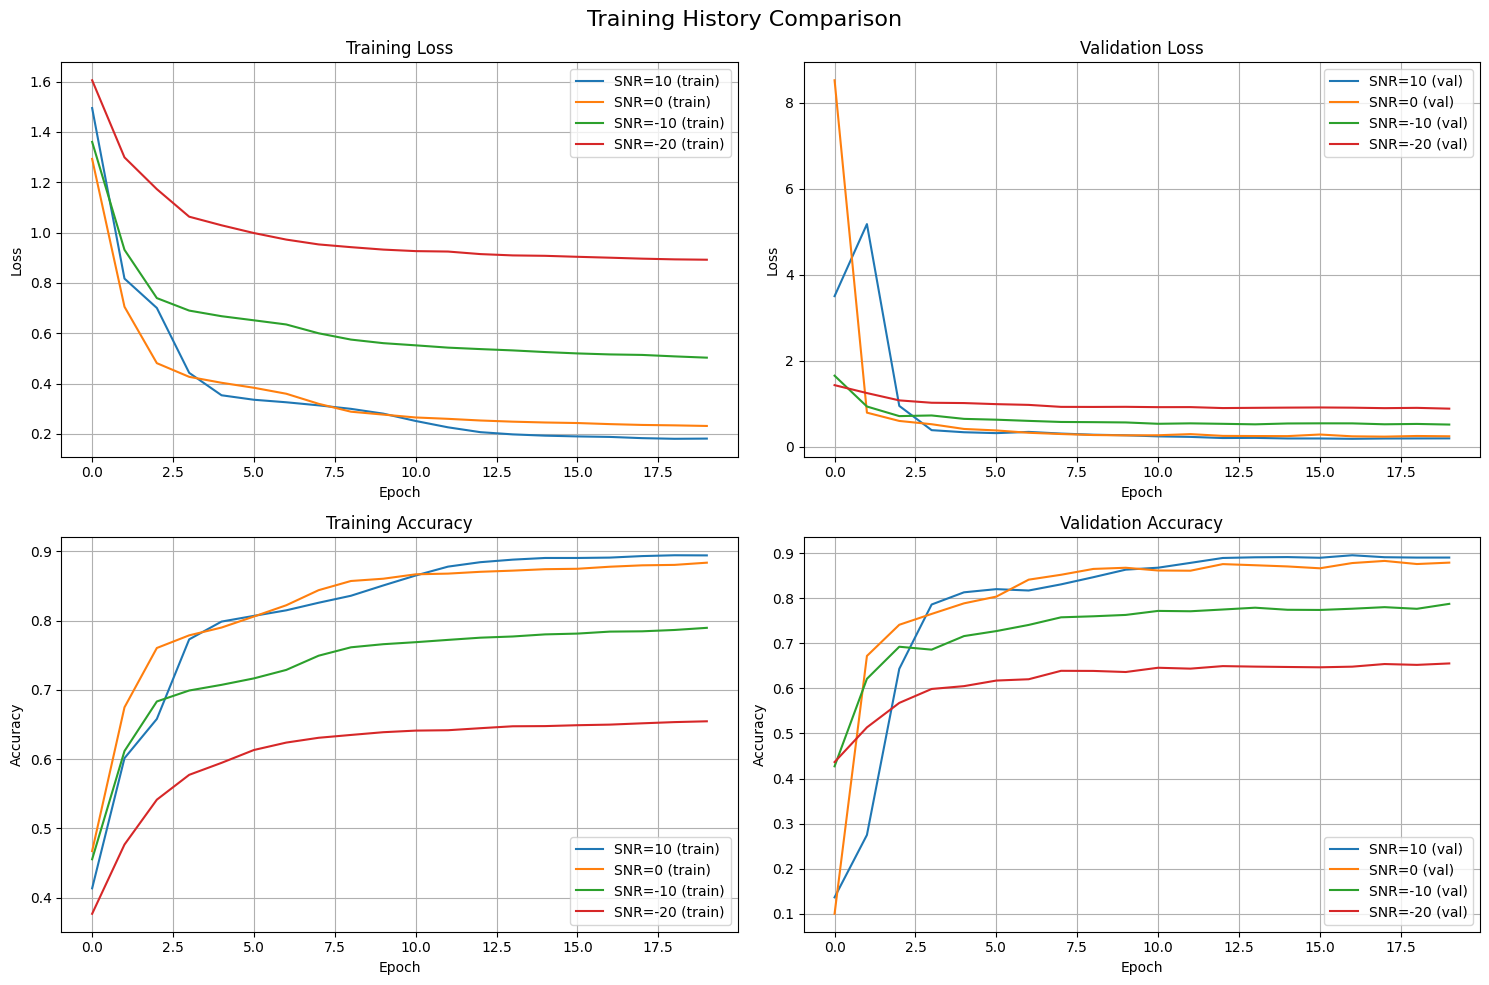

Training history plot saved to: /kaggle/working/AMC_project/figures/training_history_comparison.png


In [28]:
# Plot training history for all models
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training History Comparison', fontsize=16)

for snr_min, result in all_results.items():
    if 'history' in result and result['history'] is not None:
        history = result['history']
        
        # Loss
        axes[0, 0].plot(history.history['loss'], label=f'SNR={snr_min} (train)')
        axes[0, 1].plot(history.history['val_loss'], label=f'SNR={snr_min} (val)')
        
        # Accuracy
        axes[1, 0].plot(history.history['accuracy'], label=f'SNR={snr_min} (train)')
        axes[1, 1].plot(history.history['val_accuracy'], label=f'SNR={snr_min} (val)')

axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].set_title('Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].set_title('Training Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, 'figures', 'training_history_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Training history plot saved to: {os.path.join(BASE_DIR, 'figures', 'training_history_comparison.png')}")